In [1]:
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
import gala.coordinates as gc
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
#import HSS

import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import popsims
import astropy.units as u
import pandas as pd
from astropy.io import ascii

from shapey import Box
#from galpy.actionAngle import actionAngleIsochroneApprox
#from galpy.potential import IsochronePotential
#from galpy.potential import MWPotential
import astropy

#plt.style.use('dark_background')
%matplotlib inline

In [2]:
DATA_FOLDER='/users/caganze/research/J1624/data/'
FIG_FOLDER='/users/caganze/research/J1624/figures/'

In [3]:
#coordinate frame
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame =astro_coord.Galactocentric(galcen_distance=8.2*u.kpc,
                                    galcen_v_sun=v_sun)

#potential
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)


In [4]:
(11.1, 220+24.0, 7.25 )

(11.1, 244.0, 7.25)

In [5]:
def get_phase_space(ra, dec, pmracosdec, pmdec, distance, rv ):
    #ra, dec in degree
    #proper motions in mas/yr
    #distance in pc
    #rv in km/s
    coord=SkyCoord(ra=ra*u.degree, dec=dec*u.degree,  
               pm_ra_cosdec= pmracosdec *u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr, \
               distance=distance*u.pc, 
              radial_velocity= rv*u.km/u.s)
    #phase space position
    pos=gd.PhaseSpacePosition(coord.transform_to(galcen_frame).cartesian)
    

    return coord, pos

In [6]:
J1624_coord={'ra':46.0684208, \
              'dec': -32.2037824,\
              'pmra':np.random.normal(-25.809, 0.159, 1000),
              'pmdec':np.random.normal(-185.783, 0.122, 1000),
              'distance':np.random.normal(16.9465, 0.0356, 1000),
              'rv': np.random.normal(0.23, 0.08, 1000)}
J1624_METAL=(0.29 , 0.07)


In [7]:
#run the orbit a 1000 times incorporating the instrinsic uncertainties in rv,
#distance and proper motion

In [8]:
j1624c, pos=get_phase_space(J1624_coord['ra'], J1624_coord['dec'],\
                       J1624_coord['pmra']*np.cos(J1624_coord['dec']*u.degree), \
                       J1624_coord['pmdec'], J1624_coord['distance'], J1624_coord['rv'])

In [9]:
def compute_actions(pos, plot_all_orbit=False, alpha=1., print_pericenter=False):
    orbit=gp.Hamiltonian(pot).integrate_orbit(pos, dt=3*u.Myr, t1=0*u.Myr, \
                                              t2=2.5*u.Gyr)
    #plot 
    orbit_to_plot=orbit[:,0]
    if plot_all_orbit: orbit_to_plot=orbit
    oplot=orbit_to_plot.cylindrical.plot( components=['rho', 'z', 'v_z'],  \
                                      units=[u.pc, u.pc, u.km/u.s] ,alpha=alpha, c='#0074D9')
    #documentation: http://gala.adrian.pw/en/latest/dynamics/actionangle.html
    toy_potential = gd.fit_isochrone(orbit[:,0])
    print (toy_potential)
    print (np.shape(orbit.z))
    result = [gd.find_actions(orbit[:,idx], N_max=10, toy_potential=toy_potential) \
              for idx in tqdm(np.arange(np.shape(orbit)[-1]))]
    if  print_pericenter:
        apos=[orbit[:,idx].apocenter() for idx in tqdm(np.arange(np.shape(orbit)[-1]))]
        peris=[orbit[:,idx].pericenter() for idx in tqdm(np.arange(np.shape(orbit)[-1]))]
        print ('apocenter --- {} +/- {}'.format(np.nanmedian(u.Quantity(apos)),\
                                                np.nanstd(u.Quantity(apos))))
        print ('pericenter --- {} +/- {}'.format(np.nanmedian(u.Quantity(peris)),\
                                                 np.nanstd(u.Quantity(peris))))
    return pd.DataFrame.from_records(result), oplot


def compute_orbit_and_actions_galpy(pos, plot_all_orbit=False, alpha=1.):
    orbit=gp.Hamiltonian(pot).integrate_orbit(pos, dt=5*u.Myr, t1=0*u.Myr, \
                                              t2=2.5*u.Gyr)
    #plot 
    orbit_to_plot=orbit[:,0]
    if plot_all_orbit: orbit_to_plot=orbit
    oplot=orbit_to_plot.cylindrical.plot( components=['rho', 'z', 'v_z'],  \
                                      units=[u.pc, u.pc, u.km/u.s] ,alpha=alpha, c='#0074D9')
    ts=orbit.t
    galpyo=orbit.to_galpy_orbit()
    #ip= IsochronePotential(b=1.,normalize=1.)
    aAI= actionAngleIsochroneApprox(pot=pot.to_galpy_potential(), b=1.)
    #jfa=aAI.actionsFreqsAngles(galpyo.R(),galpyo.vR(),galpyo.vT(),galpyo.z(),\
    #                   galpyo.vz(),galpyo.phi())
    print (np.shape(galpyo.R()))
    jfa=  aAI.actionsFreqsAngles(galpyo.R().T,galpyo.vR().T,galpyo.vT().T,galpyo.z().T,\
                       galpyo.vz().T,galpyo.phi().T)
    return ts, jfa, oplot

In [10]:
#from galpy.actionAngle import actionAngleIsochroneApprox
#from galpy.potential import LogarithmicHaloPotential
#lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
#aAIA= actionAngleIsochroneApprox(pot=lp,b=0.8)

In [11]:
import gala
gala.__version__

'1.4.2.dev100+g111dba18'

In [12]:
#pot.to_galpy_potential()

IsochronePotential
(834, 1000)


  0%|                                                                                               | 0/1000 [00:00<?, ?it/s]/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_7135/384858499.py:13: GalaDeprecationWarning: The find_actions function is deprecated and may be removed in a future version.
        Use find_actions_o2gf instead.
  result = [gd.find_actions(orbit[:,idx], N_max=10, toy_potential=toy_potential) \
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-6  2  4]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [3 4 0]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_

apocenter --- 9.0701447111093 kpc +/- 0.0023702526877377216 kpc
pericenter --- 7.763938324131469 kpc +/- 0.0011430346823559118 kpc


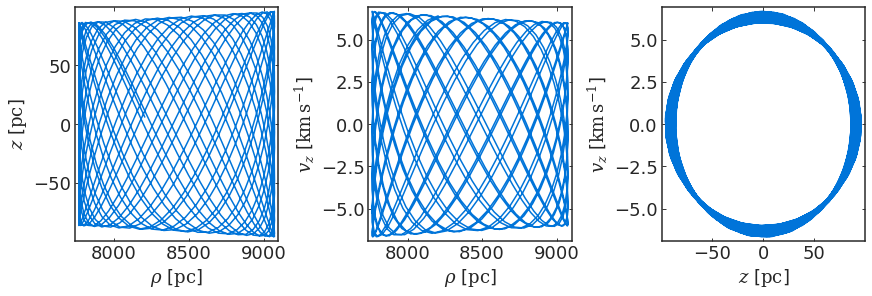

In [13]:
ares=compute_actions(pos, plot_all_orbit=False, alpha=1., print_pericenter=True)

In [14]:
(9.07-8.2)*1000, (9.07-7.7)*1000

(870.000000000001, 1370.0)

In [15]:
ares[0]['actions'][0][0].unit.to(u.kpc**2/u.Gyr)

1000.0

In [16]:
js=np.vstack(ares[0]['actions'].apply(lambda x: np.array(x)).values)
angles=np.vstack(ares[0]['angles'].apply(lambda x: np.array(x)).values)

In [17]:
np.nanmean(js[:,0])*1000, np.nanstd(js[:,0])*1000

(8.164006354777275, 0.0278029275437248)

In [18]:
np.nanmean(js[:,1])*1000, np.nanstd(js[:,1])*1000

(-1975.7746206556749, 0.29208257988928615)

In [19]:
np.nanmean(js[:,-1])*1000, np.nanstd(js[:,-1])*1000

(0.28623538922877145, 0.00612923824349093)

In [20]:
ares[0]['freqs']

0      [0.03817889182807819 rad / Myr, -0.02802343374...
1      [0.038187158032092786 rad / Myr, -0.0280293707...
2      [0.03816323785872436 rad / Myr, -0.02801225861...
3      [0.03819863718599874 rad / Myr, -0.02803764279...
4      [0.03818550068576824 rad / Myr, -0.02802823002...
                             ...                        
995    [0.03816847137883954 rad / Myr, -0.02801600187...
996    [0.0381909220320052 rad / Myr, -0.028032275320...
997    [0.03818743563270558 rad / Myr, -0.02802955013...
998    [0.03817297379522575 rad / Myr, -0.02801906101...
999    [0.03819048018061504 rad / Myr, -0.02803178485...
Name: freqs, Length: 1000, dtype: object

In [21]:
ares[-1].savefig(FIG_FOLDER+'/galatic_orbit.pdf')

In [22]:

bensby=ascii.read(DATA_FOLDER+'/bensby_30pc_gaia1.txt', \
                        names ='ra              de    \
                                [Fe/H]       age1     l_age1     u_age1       \
                                ra_gaia              de_gaia        plx       eplx    \
                                pmra      epmra       pmde      epmde      \
                                rv        erv'.split()).to_pandas()

luck=ascii.read(DATA_FOLDER+'/luck_30pc_gaia1.txt', \
               names='ra              de     [Fe/H]       age1     l_age1    \
               u_age1         ra_gaia         de_gaia        plx       eplx      \
               pmra      epmra       pmde      epmde         rv   \
               erv '.split()).to_pandas()

casgr=ascii.read(DATA_FOLDER+'/casagrande_30pc_gaia1.txt', \
                 names='ra              de     [Fe/H]      ageMP     age16P     \
                 age84P              ra_gaia              de_gaia        \
                 plx       eplx       pmra      epmra       pmde      \
                 epmde         rv        erv'.split()).to_pandas()
spocs=ascii.read(DATA_FOLDER+'/spocs_30pc_gaia1.txt', \
                 names=' ra              de     [Fe/H]       age1     l_age1     u_age1          \
                 ra_gaia              de_gaia        plx       eplx       pmra   \
                 epmra       pmde      epmde         rv        erv '.split()).to_pandas()
                 


In [23]:
luck['pmracosdec']= luck.pmra*np.cos(luck.de*u.degree)
bensby['pmracosdec']= bensby.pmra*np.cos(bensby.de*u.degree)
spocs['pmracosdec']= spocs.pmra*np.cos(spocs.de*u.degree)
casgr['pmracosdec']= casgr.pmra*np.cos(casgr.de*u.degree)

In [24]:
comb=pd.concat([bensby, luck, spocs, casgr.rename(columns={'ageMP':'age1'})])

In [25]:
bcoord, bpos=get_phase_space(comb.ra_gaia.values, comb.de_gaia.values,\
                             comb.pmracosdec.values, \
                comb.pmde.values, 1000/comb.plx.values, comb.rv.values )

IsochronePotential
(834, 1434)


  0%|                                                                                               | 0/1434 [00:00<?, ?it/s]/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_7135/384858499.py:13: GalaDeprecationWarning: The find_actions function is deprecated and may be removed in a future version.
        Use find_actions_o2gf instead.
  result = [gd.find_actions(orbit[:,idx], N_max=10, toy_potential=toy_potential) \
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-2  2  2]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [3 4 0]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_

  1%|▉                                                                                     | 15/1434 [00:04<07:52,  3.00it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-6 -4  2]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-6  0  4]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-3  0  2]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=4.17545e

  3%|██▍                                                                                   | 40/1434 [00:12<07:16,  3.19it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.35906e-24): result may not be accurate.
  angles = np.array(solve(A, b))
  3%|██▍                                                                                   | 41/1434 [00:13<07:09,  3.24it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.10918e-16): result may not be accurate.
  angles = np.array(solve(A, b))
  3%|██▌                                                                                   | 42/1434 [00:13<07:08,  3.25it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=2.10235e-21): re

  5%|████▌                                                                                 | 76/1434 [00:24<07:22,  3.07it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-4  4  4]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=6.77964e-24): result may not be accurate.
  angles = np.array(solve(A, b))
  5%|████▋                                                                                 | 78/1434 [00:25<07:36,  2.97it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-3  6  6]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/sit

  9%|███████▋                                                                             | 129/1434 [00:42<07:41,  2.83it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=6.47002e-19): result may not be accurate.
  angles = np.array(solve(A, b))
  9%|███████▋                                                                             | 130/1434 [00:42<07:37,  2.85it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-7 -4  4]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=5.29705e-21): result may not be accurate.
  angles = np.array(solve(A, b))
 10%|████████▎                                          

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.6183e-21): result may not be accurate.
  angles = np.array(solve(A, b))
 11%|█████████▌                                                                           | 162/1434 [00:53<06:58,  3.04it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-8 -2  4]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.17775e-20): result may not be accurate.
  angles = np.array(solve(A, b))
 12%|█████████▊                                                                           | 165/1434 [00:54<07:10,  2.95it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/

 14%|████████████                                                                         | 203/1434 [01:07<07:14,  2.84it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.28926e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 14%|████████████▎                                                                        | 207/1434 [01:08<06:29,  3.15it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:281: UserWarning: Need a longer integration window for mode [-6  4  6]
  warnings.warn("Need a longer integration window for mode {0}"
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.06026e-19): result may not be accurate.
  angles = np.array(solve(A, b))
 15%|████████████▎                                      

 18%|███████████████▌                                                                     | 263/1434 [01:27<06:20,  3.08it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.88064e-19): result may not be accurate.
  angles = np.array(solve(A, b))
 19%|████████████████▎                                                                    | 276/1434 [01:31<06:00,  3.22it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=5.19937e-19): result may not be accurate.
  angles = np.array(solve(A, b))
 19%|████████████████▍                                                                    | 277/1434 [01:32<06:01,  3.20it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=9.22331e-18): re

 26%|█████████████████████▊                                                               | 367/1434 [02:01<05:27,  3.26it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=4.71115e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 26%|█████████████████████▊                                                               | 368/1434 [02:02<05:25,  3.27it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=2.89408e-20): result may not be accurate.
  angles = np.array(solve(A, b))
 26%|██████████████████████                                                               | 372/1434 [02:03<05:58,  2.96it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=9.52945e-21): re

 30%|█████████████████████████▍                                                           | 429/1434 [02:22<05:56,  2.82it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.35223e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 30%|█████████████████████████▌                                                           | 431/1434 [02:23<06:25,  2.60it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.94742e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 30%|█████████████████████████▌                                                           | 432/1434 [02:24<06:19,  2.64it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=5.0157e-25): res

 35%|█████████████████████████████▍                                                       | 496/1434 [02:44<05:10,  3.02it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=2.50899e-21): result may not be accurate.
  angles = np.array(solve(A, b))
 35%|█████████████████████████████▍                                                       | 497/1434 [02:44<05:15,  2.97it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.94242e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 35%|█████████████████████████████▉                                                       | 505/1434 [02:47<05:11,  2.98it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=6.55238e-21): re

 39%|█████████████████████████████████▎                                                   | 562/1434 [03:06<04:48,  3.02it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=5.03027e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 40%|█████████████████████████████████▌                                                   | 567/1434 [03:08<05:05,  2.83it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=7.49006e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 40%|█████████████████████████████████▋                                                   | 568/1434 [03:08<05:19,  2.71it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=2.42501e-18): re

 44%|█████████████████████████████████████▋                                               | 635/1434 [03:31<04:08,  3.22it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.30811e-20): result may not be accurate.
  angles = np.array(solve(A, b))
 44%|█████████████████████████████████████▋                                               | 636/1434 [03:31<04:05,  3.25it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.69935e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 44%|█████████████████████████████████████▊                                               | 637/1434 [03:31<04:05,  3.25it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.80711e-20): re

 49%|█████████████████████████████████████████▉                                           | 708/1434 [03:54<03:59,  3.03it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.73283e-19): result may not be accurate.
  angles = np.array(solve(A, b))
 50%|██████████████████████████████████████████▎                                          | 713/1434 [03:56<04:01,  2.98it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.01522e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 50%|██████████████████████████████████████████▌                                          | 718/1434 [03:58<03:44,  3.19it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=4.62024e-17): re

 54%|█████████████████████████████████████████████▊                                       | 773/1434 [04:16<03:25,  3.22it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=4.08071e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 54%|█████████████████████████████████████████████▉                                       | 774/1434 [04:16<03:23,  3.24it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.11623e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 54%|█████████████████████████████████████████████▉                                       | 775/1434 [04:16<03:34,  3.07it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.99777e-18): re

 57%|████████████████████████████████████████████████▊                                    | 824/1434 [04:32<03:36,  2.81it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=4.30545e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 58%|████████████████████████████████████████████████▉                                    | 825/1434 [04:33<03:33,  2.85it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=2.83089e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 58%|████████████████████████████████████████████████▉                                    | 826/1434 [04:33<03:36,  2.81it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.75592e-17): re

 62%|████████████████████████████████████████████████████▊                                | 891/1434 [04:56<03:06,  2.91it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.82751e-24): result may not be accurate.
  angles = np.array(solve(A, b))
 62%|████████████████████████████████████████████████████▉                                | 894/1434 [04:57<03:00,  2.99it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=8.05586e-21): result may not be accurate.
  angles = np.array(solve(A, b))
 63%|█████████████████████████████████████████████████████▏                               | 897/1434 [04:58<03:06,  2.89it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.38098e-17): re

 66%|████████████████████████████████████████████████████████▎                            | 949/1434 [05:16<02:52,  2.81it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=4.30491e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 66%|████████████████████████████████████████████████████████▎                            | 950/1434 [05:16<02:54,  2.78it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=5.35386e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 66%|████████████████████████████████████████████████████████▍                            | 952/1434 [05:17<02:52,  2.79it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=4.60713e-17): re

 71%|███████████████████████████████████████████████████████████▍                        | 1014/1434 [05:38<02:22,  2.94it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=2.02325e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 71%|███████████████████████████████████████████████████████████▌                        | 1016/1434 [05:39<02:21,  2.95it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.69796e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 71%|███████████████████████████████████████████████████████████▋                        | 1018/1434 [05:39<02:19,  2.97it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=9.51729e-21): re

 77%|████████████████████████████████████████████████████████████████▎                   | 1098/1434 [06:06<01:46,  3.14it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=6.40966e-18): result may not be accurate.
  angles = np.array(solve(A, b))
 77%|████████████████████████████████████████████████████████████████▍                   | 1100/1434 [06:07<01:47,  3.10it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.56347e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 77%|████████████████████████████████████████████████████████████████▌                   | 1103/1434 [06:08<01:57,  2.81it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.7388e-18): res

 83%|█████████████████████████████████████████████████████████████████████▎              | 1184/1434 [06:35<01:24,  2.95it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=5.0005e-23): result may not be accurate.
  angles = np.array(solve(A, b))
 83%|█████████████████████████████████████████████████████████████████████▌              | 1187/1434 [06:36<01:22,  2.99it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.96189e-19): result may not be accurate.
  angles = np.array(solve(A, b))
 83%|█████████████████████████████████████████████████████████████████████▊              | 1191/1434 [06:38<01:23,  2.91it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.9954e-19): resu

 89%|██████████████████████████████████████████████████████████████████████████▉         | 1280/1434 [07:08<00:53,  2.88it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=4.34871e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 90%|███████████████████████████████████████████████████████████████████████████▍        | 1288/1434 [07:11<00:46,  3.13it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.07887e-20): result may not be accurate.
  angles = np.array(solve(A, b))
 90%|███████████████████████████████████████████████████████████████████████████▊        | 1295/1434 [07:13<00:44,  3.11it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=3.02918e-17): re

 96%|████████████████████████████████████████████████████████████████████████████████▎   | 1371/1434 [07:38<00:20,  3.13it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=5.22365e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 96%|████████████████████████████████████████████████████████████████████████████████▎   | 1372/1434 [07:38<00:20,  3.05it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=1.8599e-17): result may not be accurate.
  angles = np.array(solve(A, b))
 96%|████████████████████████████████████████████████████████████████████████████████▌   | 1376/1434 [07:40<00:19,  3.02it/s]/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:537: LinAlgWarning: Ill-conditioned matrix (rcond=6.41061e-20): res

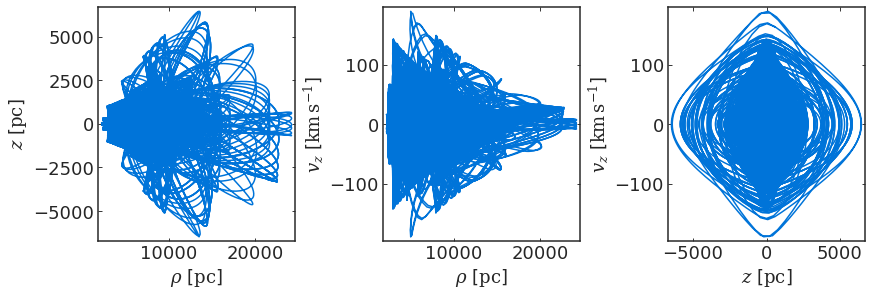

In [26]:
bensby_res=compute_actions(bpos, plot_all_orbit=True, alpha=1.)

In [27]:
bjs=np.vstack(bensby_res[0]['actions'].apply(lambda x: np.array(x)).values)
bas=np.vstack(bensby_res[0]['angles'].apply(lambda x: np.array(x)).values)
bfreqs=np.vstack(bensby_res[0]['freqs'].apply(lambda x: np.array(x)).values)

[(-0.01, 0.1), (-1.0, 10.0)]

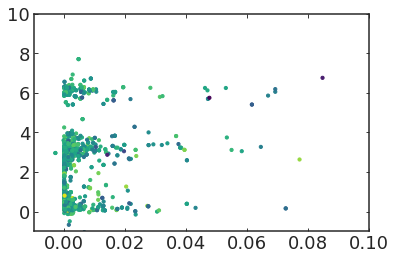

In [28]:
fig, ax=plt.subplots()
ax.scatter(bjs[:,-1], bas[:,-1], c=comb['[Fe/H]'], s=10, cmap='viridis')
ax.set(xlim=[-0.01, 0.1], ylim=[-1, 10])

In [29]:
bjs[:,2].min()

-4.467452108567127

In [30]:
comb['Jr']=bjs[:,0]*1000
comb['Jphi']=bjs[:,1]*1000
comb['Jz']=bjs[:,2]*1000
comb['vtot']=((bcoord.transform_to(galcen_frame).v_x**2+
                bcoord.transform_to(galcen_frame).v_y**2+
                bcoord.transform_to(galcen_frame).v_z**2)**0.5).value
comb['v_x']=bcoord.transform_to(galcen_frame).v_x.value
comb['v_y']=bcoord.transform_to(galcen_frame).v_y.value
comb['v_z']=bcoord.transform_to(galcen_frame).v_z.value

In [31]:
comb.head(5)

,ra,de,[Fe/H],age1,l_age1,u_age1,ra_gaia,de_gaia,plx,eplx,...,pmracosdec,age16P,age84P,Jr,Jphi,Jz,vtot,v_x,v_y,v_z
0,4.224578,-52.651123,-0.54,10.2,5.5,12.5,4.226865,-52.650335,34.0152,0.5274,...,-227.666833,NaN,NaN,109.495426,-2376.220051,0.656212,284.989261,25.286307,283.685866,10.090138
1,8.761744,-63.695180,-0.41,13.1,4.4,13.0,8.770657,-63.697480,35.0336,0.0269,...,577.435826,NaN,NaN,131.143293,-1277.478585,16.113353,160.332110,-27.589843,152.470304,41.206703
2,10.106959,-59.454602,-0.24,6.7,5.8,7.7,10.114684,-59.452627,39.5912,0.0410,...,-859.094338,NaN,NaN,651.577523,-2811.199055,2.136211,344.779305,76.863455,335.534232,-19.533509
3,10.136648,-23.804922,-0.59,12.8,7.9,13.6,10.139887,-23.806466,35.0508,0.0641,...,160.742509,NaN,NaN,37.595478,-1589.582866,23.376594,196.499059,17.185346,189.544483,48.881824
4,11.111044,-26.515682,-0.26,13.1,7.5,13.4,11.112602,-26.515018,29.3187,0.0322,...,58.557432,NaN,NaN,38.292533,-2186.550124,21.932726,265.542116,-8.931004,260.748181,-49.429125


In [32]:
comb.v_x.iloc[0]

25.286307302010055

In [47]:
#comb_r=comb.sample(n=int(1e5), replace=True)
comb_r=comb
mask= np.logical_and(comb_r.Jz>-6.5, comb_r['[Fe/H]'].between(-2, 2))

/users/caganze/research/popsims/popsims/tools.py:407: RuntimeWarning: Mean of empty slice
  zmedian= np.nanmean(data[zcol][np.logical_and(maskx, masky)])
/users/caganze/research/popsims/popsims/tools.py:423: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xgrid, ygrid, values2, vmin=vmin, vmax=vmax, cmap=cmap)


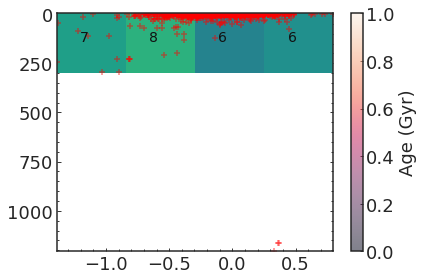

In [48]:
fig, ax=plt.subplots()

popsims.tools.plot_annotated_heatmap(ax, comb_r[['[Fe/H]', 'Jz', 'age1']][mask], 5,
                                     ['[Fe/H]', 'Jz', 'age1'], cmap='viridis', 
                           annotate='third_value', vmin=0, vmax=13, \
                                     textsize=14)
c=ax.scatter(comb['[Fe/H]'],  comb.Jz, marker='+', c='r', alpha=0.5)


cbar=plt.colorbar(c)
cbar.ax.set(ylabel='Age (Gyr)')
ax.minorticks_on()
plt.tight_layout()


In [49]:
j1624c_total_v=(j1624c.transform_to(galcen_frame).v_x**2+
            j1624c.transform_to(galcen_frame).v_y**2+
                j1624c.transform_to(galcen_frame).v_z**2)**0.5



In [50]:

 np.nanmedian(j1624c.transform_to(galcen_frame).v_z ).value


6.322677857483507

In [51]:

 np.nanstd(j1624c.transform_to(galcen_frame).v_z ).value


0.06814746118179979

In [52]:
np.nanmedian((j1624c.transform_to(galcen_frame).v_x**2+
            j1624c.transform_to(galcen_frame).v_y**2)**0.5).value

236.62974808439404

In [53]:
np.nanstd((j1624c.transform_to(galcen_frame).v_x**2+
            j1624c.transform_to(galcen_frame).v_y**2)**0.5).value

0.03551793145705334

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_7135/787312563.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_7135/787312563.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIG_FOLDER+'/orbit_age_metallicity.jpeg', rasterized=True, bbox_inches='tight')


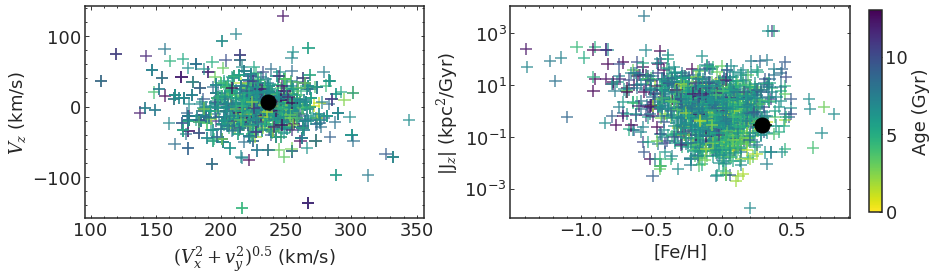

In [54]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))

ax[0].scatter((comb.v_x**2+comb.v_y**2)**0.5, comb.v_z, s=150,  c=comb.age1, \
              marker='+', alpha=.8, cmap='viridis_r', vmin=0, vmax=13)
ax[1].scatter(comb['[Fe/H]'],  abs(comb.Jz), s=150,  c=comb.age1, \
              marker='+', alpha=.8, cmap='viridis_r', vmin=0, vmax=13)


ax[0].errorbar(236, 6.33, xerr=0.036, yerr=0.067, fmt='o', ms=15, c='k')
ax[1].errorbar(J1624_METAL[0], np.nanmedian(js[:,-1]*1000), xerr=J1624_METAL[-1],\
           yerr=np.nanstd(js[:,-1]*1000), marker='o', ms=15, c='k')

ax[0].set(xlabel=r'$(V_x^2+v_y^2)^{0.5}$ (km/s) ', ylabel=r'$V_z$ (km/s)')
ax[1].set(  xlabel='[Fe/H]', \
       ylabel=r'|J$_z$| (kpc$^2$/Gyr) ', yscale='log')

norm= mpl.colors.Normalize(vmin=0,vmax=13)
mp=mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r')
cax = fig.add_axes([1.01, 0.25, .015, 0.7])
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r'Age (Gyr)', fontsize=18)

plt.tight_layout()
for a in ax:
    a.minorticks_on()
plt.savefig(FIG_FOLDER+'/orbit_age_metallicity.jpeg', rasterized=True, bbox_inches='tight')

In [84]:
#select kinematic cu
kinematic_cut=comb_r.vtot <np.nanmedian(j1624c_total_v).value
metal_cut=np.logical_and(comb_r['[Fe/H]'] <0.5,\
                         comb_r['[Fe/H]'] >0.0)   
angle_cut=  abs(comb_r.Jz)< 1

In [85]:
MEDIAN_AGE=np.nanmedian(comb_r.age1[np.logical_and.reduce([metal_cut, \
                                angle_cut, kinematic_cut])])
STD_AGE=[np.percentile(comb_r.age1[np.logical_and.reduce([metal_cut, \
                                angle_cut, kinematic_cut])], 16), \
         np.percentile(comb_r.age1[np.logical_and.reduce([metal_cut, \
                                angle_cut, kinematic_cut])], 84)]

In [57]:
#read in galah sample
#galah_sam

In [58]:
#bna

No handles with labels found to put in legend.


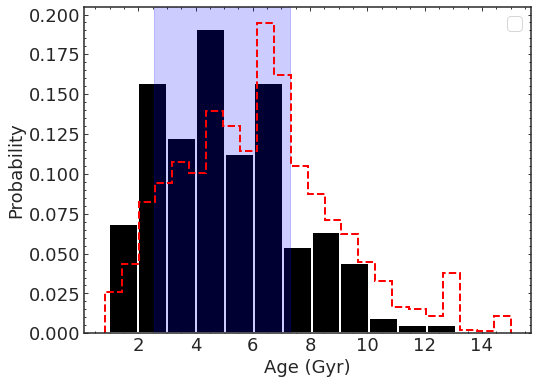

In [88]:
fig, ax=plt.subplots( figsize=(8, 6))
_=ax.hist(comb.age1, histtype='step', bins='auto', lw=2, density=True, \
          linestyle='--', color='r')
#_=sns.kdeplot(comb_r.age1, bw=0.5, lw=2, ax=ax, \
#              linestyle='-', label='sample',  color='y', alpha=0.5)

#_=sns.kdeplot(comb_r.age1[kinematic_cut], bw=0.5, lw=2, ax=ax, \
#              linestyle='dashed', label='Kinematic cut',  color='b', alpha=0.5)

#_=sns.kdeplot(comb_r.age1[metal_cut], bw=0.5, lw=2, ax=ax, \
#              alpha=0.5, color='b', linestyle='dotted', \
#          label='[Fe/H] cut')

#_=sns.kdeplot(comb_r.age1[angle_cut], bw=0.5, lw=2, ax=ax, \
#               alpha=0.5, color='b', linestyle=(0, (3, 1, 1, 1, 1, 1)),
#         label=r'$J_z$ cut')

_=ax.hist(comb_r.age1[np.logical_and.reduce([metal_cut, angle_cut, kinematic_cut])], \
              bins='auto', lw=2, density=True, \
          linestyle='-', color='k')

#ax.axvline( MEDIAN_AGE, c='k')
ax.axvspan(STD_AGE[0], STD_AGE[-1], alpha=0.2, color='blue')
ax.set(xlabel='Age (Gyr)', ylabel='Probability')
plt.legend()
ax.minorticks_on()
plt.savefig(FIG_FOLDER+'/age_constraints.pdf')

In [60]:
print (r'Age {}  -{} +{}'.format(MEDIAN_AGE, MEDIAN_AGE-STD_AGE[0],  \
                                 STD_AGE[1]-MEDIAN_AGE))

Age 4.71  -2.1768 +2.5851999999999995


In [62]:
from astropy.table import Table
merged_file='/volumes/LaCie/galah_merged.fits'
galah= Table.read(merged_file).to_pandas()

In [63]:
galah.columns

Index(['Jphi (kpc2/Myr)', 'Jr (kpc2/Myr)', 'Jz (kpc2/Myr)',
       'angle_phi_gala (rad)', 'angle_r_gala (rad)', 'angle_z_gala (rad)',
       'freq_phi_gala (rad/Myr)', 'freq_r_gala (rad/Myr)',
       'freq_z_gala (rad/Myr)', 'vx_gala (km/s)',
       ...
       'z_Rzphi_95', 'vR_Rzphi_5', 'vR_Rzphi_50', 'vR_Rzphi_95', 'vT_Rzphi_5',
       'vT_Rzphi_50', 'vT_Rzphi_95', 'vz_Rzphi_5', 'vz_Rzphi_50',
       'vz_Rzphi_95'],
      dtype='object', length=267)

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_7135/261534402.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_7135/261534402.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIG_FOLDER+'/orbit_age_metallicity_galah.jpeg', rasterized=True, bbox_inches='tight')


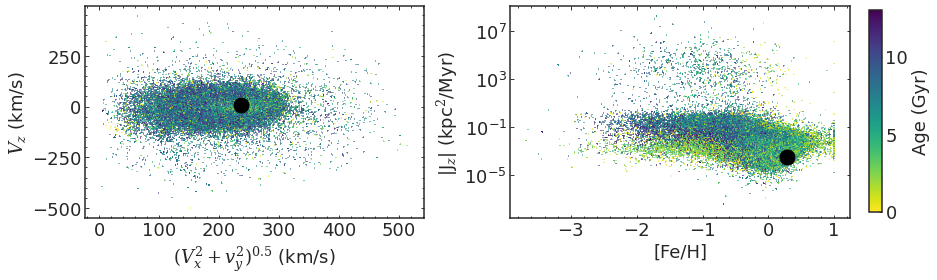

In [72]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))

ax[0].scatter((galah['vx_gala (km/s)']**2+galah['vy_gala (km/s)']**2)**0.5, \
              galah['vz_gala (km/s)'],  c=galah.age_bstep, \
              marker='+', alpha=.8, s=0.1, cmap='viridis_r', vmin=0, vmax=13)
ax[1].scatter(galah['fe_h'],  np.abs(galah['Jz (kpc2/Myr)']),   c=galah.age_bstep, \
              marker='+', alpha=.8, s=0.1,cmap='viridis_r', vmin=0, vmax=13)


ax[0].errorbar(236, 6.33, xerr=0.036, yerr=0.067, fmt='o', ms=15, c='k')
ax[1].errorbar(J1624_METAL[0], np.nanmedian(js[:,-1]), xerr=J1624_METAL[-1],\
           yerr=np.nanstd(js[:,-1]), marker='o', ms=15, c='k')

ax[0].set(xlabel=r'$(V_x^2+v_y^2)^{0.5}$ (km/s) ', ylabel=r'$V_z$ (km/s)')
ax[1].set(  xlabel='[Fe/H]', \
       ylabel=r'|J$_z$| (kpc$^2$/Myr) ', yscale='log')

norm= mpl.colors.Normalize(vmin=0,vmax=13)
mp=mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r')
cax = fig.add_axes([1.01, 0.25, .015, 0.7])
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r'Age (Gyr)', fontsize=18)

plt.tight_layout()
for a in ax:
    a.minorticks_on()
plt.savefig(FIG_FOLDER+'/orbit_age_metallicity_galah.jpeg', rasterized=True, bbox_inches='tight')

In [77]:
#galah cuts
galah_vcut=(galah['vx_gala (km/s)']**2+galah['vy_gala (km/s)']**2+ galah['vz_gala (km/s)']**2 )**0.5 <np.nanmedian(j1624c_total_v).value
galah_metal_cut=np.logical_and(galah['fe_h'] >0.29 -0.07,\
                         galah['fe_h'] <0.29 + 0.07)   
galah_angle_cut=np.logical_and(np.abs(galah['Jz (kpc2/Myr)'])>  np.nanmedian(js[:,-1])-  np.nanstd(js[:,-1]),\
                           np.abs(galah['Jz (kpc2/Myr)'])<  np.nanmedian(js[:,-1])+  np.nanstd(js[:,-1]))
                           

In [78]:
mask=np.logical_and.reduce([galah_vcut, galah_metal_cut, galah_angle_cut])

In [89]:
np.nanmedian(galah.age_bstep[mask]), np.nanstd(galah.age_bstep[mask])

(5.173024350453131, 2.2059652833985894)